# Stratification coefficient calculation

This script performs a simple calculation of the Stratification coefficient for 1-D storage in order to provide a deeper understnaing on how to assess stratification using the Stratification coefficient.

(Wu L. and Bannerot R. B., 1987, An experimental study of the effect of water extraction on thermal stratification in storage.)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from temperature_profile import temp_profile

Enter the simulation settings.

In [2]:
# Water proprties
density_water = 980 # in kg/m3
specific_heat_water = 4200  # in J/(kg K)

# Simulation properties
simulated_case = '' # Set the case that will be simulated, e.g. "fully_mixed", "fully_stratified". Otherwise, it simulates storage operation with mixing based on mixing_nodes.
heat_loss_coeff = 6 # in W/(m^2 K). This number gives a 90% storage efficiency for the selected settings. Set to 0 for no heat loss.

N = 60 # number of tank nodes
mix_nodes = int(N/10) # number of nodes close to the inlet that are mixed for imitating inlet jet mixing. Has to be integer!!!

T_hot = 90 # charge temperature
T_cold = 45 # discharge temperature
T_threshold = 10 # temperature threshold for considering the tank full/empty. E.g. if it is 10 degC then the tank is fully when the bottom is at 80 degC
T_amb = 10 # ambient temperature for calculatio of heat losses

th_cond_coeff = 2.5 # effective vertical thermal conductivity coefficient in W/(m K)
simulation_period = 1500 # This period is overwritten based on the maximum number of cycles set below. Has to be a large number!!
max_storage_cycles = 2 # stops the simulation after a number of charge-discharge cyles

plot = False # Plots the temperature profile in the tank

# Storage properties
storage_height = 1 # the height of storage in m
storage_volume = 1 # the volume of storage in m^3
volume_per_layer = 1/N # assuming that the storage is 1-D
mass_per_layer = density_water * volume_per_layer # mass per layer
storage_mass = density_water * storage_volume # total storage mass

Create dataframe containing the temperature profiles for each time step. Rows are the simulation time steps and columns are the layers of the storage starting from the top (0) to the bottom (N).

The "df_ancil" is a dataframe that contains the calculated heat loss entropy, storage entropy, heat loss (energy), energy rate, energy content, and charge status.

In [3]:
df, df_ancil = temp_profile(simulated_case, N, mix_nodes, T_hot, T_cold, T_threshold, th_cond_coeff, simulation_period,
                             heat_loss_coeff, plot=plot, max_storage_cycles=max_storage_cycles, T_amb=T_amb)

Stratification coefficient ($St$) is the mass weighted average square of the deviation of temperature $T_{i}$, which is the local temperature for each mass $m_{i}$, from the mass weighted average temperature $T_{avg}$. The higher the value of $St$ the better the stratification. As $St$ approached zero, the tank approaches a uniform temperature.

$$St = \sum_{i=1}^{N} \frac{m_{i} \cdot (T_{i}-T_{avg})^2}{m_{total}}$$

$$m_{total} = \sum_{i=1}^{N} m_{i}$$

The tank is assumed to be divided into N number of elements (usually depenig on the number of temperature measurement locations in the tank).

In [4]:
# weighted average temparature of the storage at each timestep
T_avg = (df*mass_per_layer/storage_mass).sum(axis=1)

# stratification coefficient calculation
St = ((df.subtract(T_avg, axis='rows'))**2*mass_per_layer/storage_mass).sum(axis=1)

Plot of storage temperature and stratification coefficient.

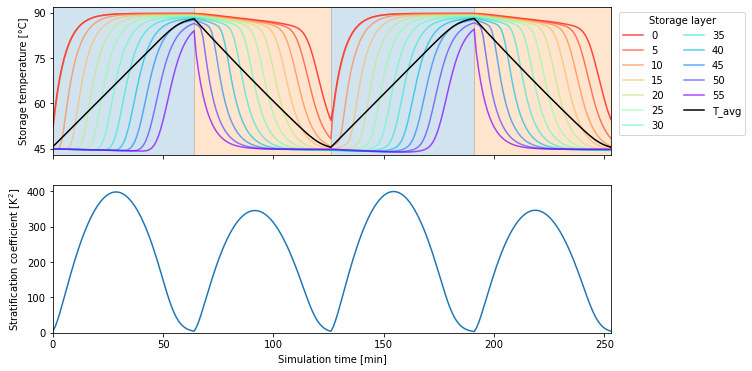

In [5]:
# Define start of charge and discharge periods
start_charge = df_ancil['charge_status'][(df_ancil['charge_status'].diff() != 0) & (df_ancil['charge_status'] == 1)].index.tolist()
# The previous timestep is the one where the change actually happens!!
start_charge = [x - 1 for x in start_charge]
# Add the end of the simulation in the end
start_charge.append(df.index[-1])

# Same for discharge
start_discharge = df_ancil['charge_status'][(df_ancil['charge_status'].diff() != 0) & (df_ancil['charge_status'] == 0)].index.tolist()
start_discharge = [x - 1 for x in start_discharge]


fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True, figsize=(10,6))
_ = df[np.arange(0,df.shape[1],5)].plot(ax=ax1, cmap='rainbow_r', alpha=0.7)
ax1.plot(T_avg, c='k', label='T_avg')

x = df.index

ax2.plot(St)
ax1.set_ylabel('Storage temperature [°C]')
ax2.set_ylabel('Stratification coefficient [K$^2$]')
ax2.set_xlabel('Simulation time [min]')
ax2.set_ylim(0, None)

ax1.set_ylim(43, 92)
ax1.set_yticks(np.arange(45,90+15,15))
ax2.set_xlim(0, df.index[-1])

for i in range(len(start_charge)-1):
    ax1.axvspan(start_charge[i], start_discharge[i], color="C0", alpha=0.2, label='')
    ax1.axvspan(start_discharge[i], start_charge[i+1], color="C1", alpha=0.2, label='')

ax1.legend(ncol=2, title='Storage layer', loc=1, bbox_to_anchor=(1.25, 1))

### Comments on Stratification coefficient

It is only useful for comparing two (or more) storages as it cannot give a value for "good" stratification. When the stratification coefficient is zero then the temperature in the storage is uniform. Essentially any value higher than zero indicates some level of stratification inside the storage.

However, it is easy to calculate and straightforward in its understanding.


The charge rate is relatively independent of heat losses, whereas the discharge rate is more affected. This can be observed also in the storage temperatures. The reason is that the hot water looses much more energy than the cold water, so when the tank is fully charged expereinces more heat loss thus resulting in lower discharge temperature.